This is a notebook which combines the code from notebooks 1_Concat_scoring_method to 4_analyse_benchmark into one notebook for faster analysis, but even more condensed than the pipeline notebook for faster analysis, only computing correlation coefficients between experimental and predicted energies. These notebooks are taken from Frappier et al. (2019) https://www.sciencedirect.com/science/article/pii/S0969212619300085

In [1]:
import glob
import re
import os
import requests
import subprocess
import copy as vcopy
import pickle
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from scipy.stats import rankdata, ttest_rel
from sklearn import metrics
import seaborn as sns

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
CHAIN_LENGTH = 20

# CHANGE THESE
# ETAB_FOLDER = "../../all_terminator_evals/bcl2/terminator_eval_condensed/term_m/run0/*.etab.npy"
# FILE_SUFFIX = "ingraham_coords"

In [3]:
myAmino = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
FullAmino = ['ALA', 'CYS', 'ASP', 'GLU', 'PHE', 'GLY', 'HIS', 'ILE', 'LYS', 'LEU', 'MET', 'ASN', 'PRO', 'GLN', 'ARG', 'SER', 'THR', 'VAL', 'TRP', 'TYR']
aminos = {FullAmino[i]:myAmino[i] for i in range(len(myAmino))}

# zero is used as padding
AA_to_int = {'A': 1,'ALA': 1,'C': 2,'CYS': 2,'D': 3,'ASP': 3,'E': 4,'GLU': 4,'F': 5,'PHE': 5,'G': 6,'GLY': 6,'H': 7,'HIS': 7,'I': 8,'ILE': 8,'K': 9,'LYS': 9,'L': 10,'LEU': 10,'M': 11,'MET': 11,'N': 12,'ASN': 12,'P': 13,'PRO': 13,'Q': 14,'GLN': 14,'R': 15,'ARG': 15,'S': 16,'SER': 16,'T': 17,'THR': 17,'V': 18,
'VAL': 18,'W': 19,'TRP': 19,'Y': 20,'TYR': 20,'X': 21}
## amino acid to integer
atoi = {key: val - 1 for key, val in AA_to_int.items()}
## integer to amino acid
iota = {y: x for x, y in atoi.items() if len(x) == 1}

In [4]:
#Benchmark dataset from SORTCERY
AllName = ["x1","m1","f100"]
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]
ApoDTerm = False

In [5]:
#Dictionnary of energy (exp or predicted)
PepBindEner = dict()

#Get Energy from sortery
for (t,name) in zip(AllName,NameTest):
    subdf = pd.read_csv("../SORTCERY_data/"+t+"_merged.csv")
    
    if name not in PepBindEner:
        PepBindEner[name] = dict()
    for (seq,val) in zip(subdf["protein"],subdf[t+"_mean_ener"]):
        if seq in PepBindEner[name]:
            print(name,seq,val,PepBindEner[name][seq])
        PepBindEner[name][seq] = float(val)
    print(t,name,len(subdf),len(PepBindEner[name]))

x1 B2CL1_SORTCERY 4386 4386
m1 MCL1_SORTCERY 4491 4491
f100 B2LA1_SORTCERY 3805 3805


In [6]:
#Score seq using energy function
def score_sec(seq,mat):
    sc = 0.0
    chain_size = len(seq)
    for i in range(0, chain_size):
        amino1 = atoi[seq[i]]
        for j in range(i, chain_size):
            amino2 = atoi[seq[j]]
            sc += mat[i][j][amino1][amino2]
    return sc

In [7]:
scores = {}

In [10]:
models = ['term_m', 'term_s', 'coord_m', 'coord_s']
runs = ['run0', 'run1', 'run2']
all_bench_cors = {}
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = glob.glob(f"../../bcl2/terminator_eval_condensed/{m}/{r}/*.etab.npy")
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue

            # print("now scoring:", model)
            if nmodel not in PepBindEner:
                PepBindEner[nmodel] = dict()
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                ener = score_sec(SeqToScore,holo)
                PepBindEner[nmodel][seq] = ener
        
            
        PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

        #New name
        NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

#         all_cors = []

        for bench in NameTest:
            print(bench)
            ExpRec = bench.split("_")[0]
            #Get bench
            OnlyBench = PepBindEnerDF.dropna(subset=[bench])

#             cors = []

            count = 0 
            for template in list(PepBindEnerDF.columns):
                if template == bench:continue
                #Need to be same receptor
                TempRec = template.split("_")[0]
                if TempRec != ExpRec:
                    continue
                    
                #Get PDB and model name
                sp = template.split("_")
                mod = sp[-1]
                if mod != 'dTERMenC35':
                    continue

                pdb = "_".join(sp[:4])
                if "MIN" in template:
                    pdb = "_".join(sp[:3])
                
                #Get data
                subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
                Pred = subdf[template].values
                Exp = subdf[bench].values
                
                #Pearson product-moment correlation coefficients
                cor = np.corrcoef(Pred,Exp)[0][1]
                
                bench_cors[bench].append(cor)
#                 cors.append(cor)
#                 print(template, cor)        
                #Get Enrich
                topbind = rankdata(Exp) < len(Exp) / 10
                enrich = np.sum(topbind[:len(Exp)//10])/(len(Exp)/10.0)*100

#             print(np.mean(cors))
#             print(np.std(cors))
    
    all_bench_cors[m] = bench_cors
#     print("bench cors")
#     all_cors = []
#     for key in bench_cors:
#         print(key)
#         print(np.mean(bench_cors[key]))
#         print(np.std(bench_cors[key]))
#         all_cors.append(np.mean(bench_cors[key]))
#     print("all cors")
#     print(np.mean(all_cors))
#     print(np.std(all_cors))
print(all_bench_cors)

term_m/run0


KeyboardInterrupt: 

In [7]:
models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0_10', 'run1_10', 'run2_10']
all_bench_cors = {}
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = sorted(glob.glob(f"../../bcl2/terminator_eval_condensed/include_nlcpl/{m}/{r}/*.etab.npy"))
        for etab in alletab:
            if m == 'coordm':
                model = os.path.basename(etab)
            else:
                model = os.path.basename(etab)[len(r):] # because of a mishap when computing/naming these
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue
            
            preds = []
            exps = []
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                pred_ener = score_sec(SeqToScore,holo)
                exp_ener = PepBindEner[rec+"_SORTCERY"][seq]
                preds.append(pred_ener)
                exps.append(exp_ener)
            
            cor = np.corrcoef(preds,exps)[0][1]
            bench_cors[rec+"_SORTCERY"].append(cor)
            
    all_bench_cors[m] = bench_cors
print(all_bench_cors)

termm/run0_10
termm/run1_10
termm/run2_10
terms/run0_10
terms/run1_10
terms/run2_10
coordm/run0_10
coordm/run1_10
coordm/run2_10
coords/run0_10
coords/run1_10
coords/run2_10
{'termm': {'B2CL1_SORTCERY': [0.4580447757214433, 0.32764215083192477, 0.23915416957083216, 0.297387636982108, 0.26852454901339123, 0.39135855920831514, 0.12454901897878672, 0.4199886753989829, 0.29163737986898736, 0.2752726474632998, 0.20659112785706166, 0.4435167216489377, 0.15842049965658603, 0.18452421940523903, 0.1137029247108214, 0.43591295729960466, 0.3453684935458046, 0.33365077371746293, 0.24741854428022048, 0.2848559096284113, 0.2777685406540586, 0.21238974480657122, 0.3007646671739353, 0.3102772678316158, 0.36815722668331985, 0.19449203573108037, 0.3921229922159142, 0.1622318990201382, 0.1886767208180808, 0.05647570849939168, 0.30825678010200835, 0.3429336684781593, 0.27853582974631785, 0.25662619139391185, 0.2742929895696609, 0.2975862856987543, 0.19141090101556613, 0.456502846447979, 0.4569186210294733

In [8]:
for k in ['termm', 'terms', 'coordm', 'coords']:
    print(np.mean(all_bench_cors[k]['B2LA1_SORTCERY']))
    print(np.std(all_bench_cors[k]['B2LA1_SORTCERY']))

0.4904059491741555
0.049714923221906716
0.4841900412087926
0.03542378698990792
0.4786769007351183
0.04312704040296013
0.47732836661480665
0.043208517338423805


In [7]:
# alex experiments

models = ['multichain_delete_tic_nlcpl_test_run1', 'multichain_gvp_delete_tic_l1_0.005', 'multichain_gvp_delete_tic_l2_0.5', 'multichain_gvp_delete_tic_nlcpl_test_run1']
all_bench_cors = {}
for m in models:
    print(m)
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    alletab = sorted(glob.glob(f"/data1/groups/keatinglab/alexjli/refactor_dirs/data/outputs/bcl2_condensed/{m}/*.etab.npy"))
    for etab in alletab:
        model = os.path.basename(etab)
        if "BCL2" in model or "HUMAN" not in model:
            continue

        # sp = (model+"_35").split("_")
        model = model[:-9] + "_35" + model[-9:]
        sp = model.split("_")
        if len(sp) != 6:
            continue
        rec = sp[0]

        scoring = "dTERMenC"
        sp[-1] = scoring+sp[-1][:2]
        nmodel = "_".join(sp)

        #Load scoring matrix
        holo = np.load(etab)

        if len(holo) != CHAIN_LENGTH: # check for length 20 chain
            print(model,len(holo))
            continue

        preds = []
        exps = []
        for seq in PepBindEner[rec+"_SORTCERY"]:
            #dTERMen pep are shorter, so need to adjust
            SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
            #Score Seq
            pred_ener = score_sec(SeqToScore,holo)
            exp_ener = PepBindEner[rec+"_SORTCERY"][seq]
            preds.append(pred_ener)
            exps.append(exp_ener)

        cor = np.corrcoef(preds,exps)[0][1]
        bench_cors[rec+"_SORTCERY"].append(cor)
            
    all_bench_cors[m] = bench_cors
print(all_bench_cors)

multichain_delete_tic_nlcpl_test_run1
multichain_gvp_delete_tic_l1_0.005
multichain_gvp_delete_tic_l2_0.5
multichain_gvp_delete_tic_nlcpl_test_run1
{'multichain_delete_tic_nlcpl_test_run1': {'B2CL1_SORTCERY': [0.3630646046658895, 0.1886570265630237, 0.23935423616623797, 0.28183439553490297, 0.17088949619774949, 0.24847093717068622, 0.027676301600564734, 0.24085899557196008, 0.39904189057686157, 0.17523970676739498, 0.13472031294757003, 0.21593939009746782, 0.11650443057896756, 0.06983553959236526, 0.003302924116030292], 'MCL1_SORTCERY': [0.38014706714550434, 0.5149151668028294, 0.5544540576946275, 0.5710782477392433, 0.5772849100931032, 0.38711599332765684, 0.5397995815698373, 0.5340452945581962, 0.4865042610350083, 0.5016024712375933, 0.3572771119217526, 0.386530327909194, 0.4369433374234928, 0.4621761438481398, 0.35737731859816435, 0.3925139639088675, 0.378551890590749, 0.39211589710950706, 0.41917530169310757, 0.4213834652636797, 0.4137968029143395, 0.4194248190128751, 0.43097880172

In [7]:
all_bench_cors = {'multichain_delete_tic_nlcpl_test_run1': {'B2CL1_SORTCERY': [0.3630646046658895, 0.1886570265630237, 0.23935423616623797, 0.28183439553490297, 0.17088949619774949, 0.24847093717068622, 0.027676301600564734, 0.24085899557196008, 0.39904189057686157, 0.17523970676739498, 0.13472031294757003, 0.21593939009746782, 0.11650443057896756, 0.06983553959236526, 0.003302924116030292], 'MCL1_SORTCERY': [0.38014706714550434, 0.5149151668028294, 0.5544540576946275, 0.5710782477392433, 0.5772849100931032, 0.38711599332765684, 0.5397995815698373, 0.5340452945581962, 0.4865042610350083, 0.5016024712375933, 0.3572771119217526, 0.386530327909194, 0.4369433374234928, 0.4621761438481398, 0.35737731859816435, 0.3925139639088675, 0.378551890590749, 0.39211589710950706, 0.41917530169310757, 0.4213834652636797, 0.4137968029143395, 0.4194248190128751, 0.43097880172654013, 0.3878801716420829, 0.1348580570377779, 0.2302308483153883], 'B2LA1_SORTCERY': [0.43510672355933006, 0.4034321084221824, 0.451129074126693, 0.27328031190488644, 0.30479470615686866, 0.4213666274573189]}, 'multichain_gvp_delete_tic_l1_0.005': {'B2CL1_SORTCERY': [0.4038317749688358, 0.09937088233092664, 0.2812010036328071, 0.23206902676648528, 0.18618373725052462, 0.2356736802486804, 0.18188209418923076, 0.22285954473422925, 0.3455737615935867, 0.13243425786844937, 0.16577241385892236, 0.26820493853949295, 0.15670257748192884, 0.062322975693541796, -0.08667907810984808], 'MCL1_SORTCERY': [0.38537802567483476, 0.47781433345887636, 0.5255537112736227, 0.6052475036487371, 0.5944982781864995, 0.5567467574090365, 0.559257069230375, 0.6032289898721406, 0.5417569499115255, 0.5594869826946665, 0.4822340065916885, 0.4698102710912163, 0.5287753329437529, 0.6038339117895215, 0.40755076966837656, 0.4111526167494109, 0.4356629377615664, 0.4921656993027125, 0.4929043488395973, 0.5472812433781192, 0.4404916868987945, 0.5269230461568074, 0.5148074359912788, 0.5209918939451336, -0.025429079546649646, 0.03693919870588178], 'B2LA1_SORTCERY': [0.426283935346931, 0.38597393730851665, 0.44420322097226855, 0.25553487849639545, 0.11057280096961011, 0.34775127230896824]}, 'multichain_gvp_delete_tic_l2_0.5': {'B2CL1_SORTCERY': [0.36212465991048404, 0.14767957286612013, 0.2261921442925932, 0.19699741966266912, 0.20950950050452122, 0.23490192063643467, 0.08610555436130869, 0.22097513995314427, 0.2581791488498858, 0.19960443780782453, 0.06223821254974692, 0.28661574385238753, 0.15703472464470583, 0.12672377793108558, -0.047355316839634454], 'MCL1_SORTCERY': [0.3775463047806762, 0.556302494232904, 0.5588368364689804, 0.6334711656798614, 0.6227863748154483, 0.5561009145539344, 0.5925053914941182, 0.6286581981378605, 0.5544364364474196, 0.5796468497613453, 0.3296953319090847, 0.3648768983554878, 0.5291497735682048, 0.5709105740218176, 0.454436936756156, 0.42419951323071586, 0.45182000029297303, 0.5097122597848754, 0.49245587698593113, 0.5141379306972348, 0.4368659571694322, 0.5357991520005104, 0.4463602729432689, 0.5217140322945598, -0.023646675466442994, -0.004923214386343786], 'B2LA1_SORTCERY': [0.4434974950867086, 0.40756173097237586, 0.4471023776007525, 0.2630912334142845, 0.21203059231827834, 0.3506431911536979]}, 'multichain_gvp_delete_tic_nlcpl_test_run1': {'B2CL1_SORTCERY': [0.3147389607621861, 0.16411526099770873, 0.3029745272719799, 0.34419251967388337, 0.3042510326463793, 0.29761826921505186, 0.15369621563306443, 0.23094123202375258, 0.21950763196430964, 0.07067801066134478, 0.2264334267405771, 0.2996245468553214, 0.21894363635493386, 0.08877933112757248, -0.013856846941535052], 'MCL1_SORTCERY': [0.3547259291544424, 0.4811262731241688, 0.5393843826908655, 0.5902350005439081, 0.5971651776537914, 0.5707734021317207, 0.5437249956091385, 0.6113430058937726, 0.5342516594308876, 0.562663134190038, 0.430249974003933, 0.44253505166791535, 0.5326917794331179, 0.5788836250833148, 0.48087310492393115, 0.44754699124656283, 0.47464484262179835, 0.45844905814194725, 0.5313057939508665, 0.5060442368375153, 0.4920059047066024, 0.49199511631096127, 0.44216132477620923, 0.4934819287893806, 0.12686558397505715, 0.1280989803511242], 'B2LA1_SORTCERY': [0.41133372155486125, 0.4136084854125921, 0.4299027493286243, 0.18783279710242748, 0.20284521419689028, 0.3905943139056717]}}

In [11]:
models = ['multichain_delete_tic_nlcpl_test_run1', 'multichain_gvp_delete_tic_l1_0.005', 'multichain_gvp_delete_tic_l2_0.5', 'multichain_gvp_delete_tic_nlcpl_test_run1']
for m in models:
    print(m)
    print("Bcl-xL", np.mean(all_bench_cors[m]['B2CL1_SORTCERY']), np.std(all_bench_cors[m]['B2CL1_SORTCERY']))
    print("Bfl-1", np.mean(all_bench_cors[m]['B2LA1_SORTCERY']), np.std(all_bench_cors[m]['B2LA1_SORTCERY']))
    print("Mcl-1", np.mean(all_bench_cors[m]['MCL1_SORTCERY']), np.std(all_bench_cors[m]['MCL1_SORTCERY']))

multichain_delete_tic_nlcpl_test_run1
Bcl-xL 0.1916926792098448 0.10827164329887358
Bfl-1 0.38151825860454663 0.06756164485598184
Mcl-1 0.42569851192766384 0.09760990688788153
multichain_gvp_delete_tic_l1_0.005
Bcl-xL 0.19249357273651962 0.11412261619646544
Bfl-1 0.32838667423378165 0.11506439811937122
Mcl-1 0.4728870739087509 0.14793949357392255
multichain_gvp_delete_tic_l2_0.5
Bcl-xL 0.18183510939888511 0.09583094242042714
Bfl-1 0.3539877700910163 0.08942193727334405
Mcl-1 0.46976367640500055 0.16049390252679122
multichain_gvp_delete_tic_nlcpl_test_run1
Bcl-xL 0.21484251699910206 0.1007421229560339
Bfl-1 0.3393528802501779 0.10256118353985717
Mcl-1 0.4785856252785758 0.1170317907870406


In [8]:
all_bench_cors = {}
models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0_100', 'run1_100', 'run2_100']
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = sorted(glob.glob(f"../../bcl2/terminator_eval_condensed/include_nlcpl/{m}/{r}/*.etab.npy"))
        for etab in alletab:
            if m == 'coordm':
                model = os.path.basename(etab)
            else:
                model = os.path.basename(etab)[len(r):] # because of a mishap when computing/naming these
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue
            
            preds = []
            exps = []
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                pred_ener = score_sec(SeqToScore,holo)
                exp_ener = PepBindEner[rec+"_SORTCERY"][seq]
                preds.append(pred_ener)
                exps.append(exp_ener)
            
            cor = np.corrcoef(preds,exps)[0][1]
            bench_cors[rec+"_SORTCERY"].append(cor)
            
    all_bench_cors[m] = bench_cors
print(all_bench_cors)

termm/run0_100
termm/run1_100
termm/run2_100
terms/run0_100
terms/run1_100
terms/run2_100
coordm/run0_100
coordm/run1_100
coordm/run2_100
coords/run0_100
coords/run1_100
coords/run2_100
{'termm': {'B2CL1_SORTCERY': [0.5012578131329488, 0.358580222972323, 0.31041491677165417, 0.3523524610063045, 0.29911491779374544, 0.4054879579632198, 0.3051465969614293, 0.40520844879523793, 0.3196482139313969, 0.3214479023260589, 0.2114000429302333, 0.487195906760901, 0.21850542966482023, 0.26880040405642813, 0.22531324947117679, 0.5038694273528053, 0.43123909220892287, 0.3641444621153014, 0.30119427210849475, 0.3093858058900718, 0.3338344632661264, 0.35860074751771304, 0.3893278158185204, 0.3532602444158443, 0.32584193457865274, 0.15942979336497198, 0.4134543036691925, 0.24524478363323368, 0.235973418747802, 0.13687927917202403, 0.40742226497991996, 0.4221562122867216, 0.20377774338187685, 0.22074149165116388, 0.22789488649746276, 0.24132201046355653, 0.1946973291332767, 0.4467861079216252, 0.4429944

In [10]:
for k in ['termm', 'terms', 'coordm', 'coords']:
    print(k)
    print(np.mean(all_bench_cors[k]['B2LA1_SORTCERY']))
    print(np.std(all_bench_cors[k]['B2LA1_SORTCERY']))    

termm
0.5196931651435884
0.04938817842085035
terms
0.5094431335385363
0.03091701125869302
coordm
0.5082233774399206
0.03854667754160783
coords
0.514398486492618
0.03178260218391207


In [11]:
models = ['term_m', 'term_s', 'coord_m', 'coord_s']
runs = ['run0', 'run1', 'run2']
all_bench_cors = {}
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = sorted(glob.glob(f"../../bcl2/terminator_eval_condensed/{m}/{r}/*.etab.npy"))
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue
            
            preds = []
            exps = []
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                pred_ener = score_sec(SeqToScore,holo)
                exp_ener = PepBindEner[rec+"_SORTCERY"][seq]
                preds.append(pred_ener)
                exps.append(exp_ener)
            
            cor = np.corrcoef(preds,exps)[0][1]
            bench_cors[rec+"_SORTCERY"].append(cor)
            
    all_bench_cors[m] = bench_cors
print(all_bench_cors)

term_m/run0
term_m/run1
term_m/run2
term_s/run0
term_s/run1
term_s/run2
coord_m/run0
coord_m/run1
coord_m/run2
coord_s/run0
coord_s/run1
coord_s/run2
{'term_m': {'B2CL1_SORTCERY': [0.40711634824117643, 0.19535300791409027, 0.18601577219286758, 0.16341302681114972, 0.20096607389851703, 0.2685724731931641, 0.07378157296955437, 0.3922440832109884, 0.27042039651344846, 0.2775925553872256, 0.0753072221596761, 0.2747624560032465, 0.17811220084868049, 0.17563020871625443, 0.021275513916597443, 0.3832795190207283, 0.2930978953053006, 0.3286735701850055, 0.3081669415626642, 0.25540381009108226, 0.35993638067936345, 0.06930173953995994, 0.38014833683616417, 0.31997088626334264, 0.40474899768211503, 0.18345861751222534, 0.3401056927654721, 0.1379932911224573, 0.1443727678206546, -0.0015320935999018595, 0.3043955838099908, 0.23507099877242935, 0.16211420533169918, 0.14772875199543722, 0.13803983118598548, 0.16791512074462286, 0.025489876765675677, 0.4594334235407075, 0.3461205045516765, 0.23249320

In [12]:
models = ['termm', 'terms', 'coordm', 'coords']
runs = ['run0', 'run1', 'run2']
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = sorted(glob.glob(f"../../bcl2/terminator_eval_condensed/triplicate/{m}/{r}/*.etab.npy"))
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue
            
            preds = []
            exps = []
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                pred_ener = score_sec(SeqToScore,holo)
                exp_ener = PepBindEner[rec+"_SORTCERY"][seq]
                preds.append(pred_ener)
                exps.append(exp_ener)
            
            cor = np.corrcoef(preds,exps)[0][1]
            bench_cors[rec+"_SORTCERY"].append(cor)
     
    all_bench_cors[m] = bench_cors
print(all_bench_cors)

termm/run0
termm/run1
termm/run2
terms/run0
terms/run1
terms/run2
coordm/run0
coordm/run1
coordm/run2
coords/run0
coords/run1
coords/run2
{'term_m': {'B2CL1_SORTCERY': [0.40711634824117643, 0.19535300791409027, 0.18601577219286758, 0.16341302681114972, 0.20096607389851703, 0.2685724731931641, 0.07378157296955437, 0.3922440832109884, 0.27042039651344846, 0.2775925553872256, 0.0753072221596761, 0.2747624560032465, 0.17811220084868049, 0.17563020871625443, 0.021275513916597443, 0.3832795190207283, 0.2930978953053006, 0.3286735701850055, 0.3081669415626642, 0.25540381009108226, 0.35993638067936345, 0.06930173953995994, 0.38014833683616417, 0.31997088626334264, 0.40474899768211503, 0.18345861751222534, 0.3401056927654721, 0.1379932911224573, 0.1443727678206546, -0.0015320935999018595, 0.3043955838099908, 0.23507099877242935, 0.16211420533169918, 0.14772875199543722, 0.13803983118598548, 0.16791512074462286, 0.025489876765675677, 0.4594334235407075, 0.3461205045516765, 0.2324932074364962, 0.

In [12]:
from scipy.stats import ttest_rel

In [37]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

for f in families:
    print(f)
#     print(means["term_m"][f])
#     print(means["termm"][f])
    print(ttest_rel(means["term_m"][f], means["termm_reg"][f]))

B2CL1_SORTCERY
Ttest_relResult(statistic=6.570168619749269, pvalue=1.248970934402612e-05)
MCL1_SORTCERY
Ttest_relResult(statistic=-6.483275690226506, pvalue=8.63986380639241e-07)
B2LA1_SORTCERY
Ttest_relResult(statistic=0.3888752907984765, pvalue=0.7133773174978648)


In [16]:
models = ['termm_reg', 'terms_reg', 'coordm_reg', 'coords_reg']
runs = ['run0', 'run1', 'run2']
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = sorted(glob.glob(f"../../bcl2/terminator_eval_condensed/{m}/{r}/*.etab.npy"))
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue
            
            preds = []
            exps = []
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                pred_ener = score_sec(SeqToScore,holo)
                exp_ener = PepBindEner[rec+"_SORTCERY"][seq]
                preds.append(pred_ener)
                exps.append(exp_ener)
            
            cor = np.corrcoef(preds,exps)[0][1]
            bench_cors[rec+"_SORTCERY"].append(cor)
            
    all_bench_cors[m] = bench_cors
print(all_bench_cors)

termm_reg/run0
termm_reg/run1
termm_reg/run2
terms_reg/run0
terms_reg/run1
terms_reg/run2
coordm_reg/run0
coordm_reg/run1
coordm_reg/run2
coords_reg/run0
coords_reg/run1
coords_reg/run2
{'term_m': {'B2CL1_SORTCERY': [0.40711634824117643, 0.19535300791409027, 0.18601577219286758, 0.16341302681114972, 0.20096607389851703, 0.2685724731931641, 0.07378157296955437, 0.3922440832109884, 0.27042039651344846, 0.2775925553872256, 0.0753072221596761, 0.2747624560032465, 0.17811220084868049, 0.17563020871625443, 0.021275513916597443, 0.3832795190207283, 0.2930978953053006, 0.3286735701850055, 0.3081669415626642, 0.25540381009108226, 0.35993638067936345, 0.06930173953995994, 0.38014833683616417, 0.31997088626334264, 0.40474899768211503, 0.18345861751222534, 0.3401056927654721, 0.1379932911224573, 0.1443727678206546, -0.0015320935999018595, 0.3043955838099908, 0.23507099877242935, 0.16211420533169918, 0.14772875199543722, 0.13803983118598548, 0.16791512074462286, 0.025489876765675677, 0.459433423540

In [15]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

# for f in families:
#     print(f)
#     print(all_bench_cors["term_m"][f])
#     print(all_bench_cors["termm_reg"][f])
#     print(ttest_rel(all_bench_cors["term_m"][f], all_bench_cors["termm_reg"][f]))

In [22]:
np.mean(all_bench_cors["termm_reg"]["B2LA1_SORTCERY"])

0.3554171259559389

In [16]:
means = {}
for model in all_bench_cors:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for f in families:
        num_templates = len(all_bench_cors[model][f])//3
        for j in range(num_templates):
            bench_cors[f].append((all_bench_cors[model][f][j]+all_bench_cors[model][f][num_templates+j]+all_bench_cors[model][f][2*num_templates+j])/3)
    means[model] = bench_cors
# print(means)

In [26]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

for f in families:
    print(f)
    print(means["term_m"][f])
    print(means["termm_reg"][f])
    print(ttest_rel(means["term_m"][f], means["termm_reg"][f]))

B2CL1_SORTCERY
[0.3649304836906318, 0.24117396733060673, 0.22560118256985742, 0.2064362401230837, 0.19813657172519494, 0.2654746582057168, 0.05619106309173, 0.4106086145292867, 0.31217059577615586, 0.3049449201686123, 0.12711320317992691, 0.29716563128719375, 0.14272728324578018, 0.15515131558254333, -0.003186489611380934]
[0.33057470963225266, 0.20910150702799826, 0.10921631485707058, 0.11442357359012871, 0.056178286821162486, 0.11406575471633977, 0.04042615760143808, 0.27178741963518194, 0.2988528917605549, 0.18863280228406112, -0.024039891307666417, 0.26254644080277734, 0.054570097457356186, 0.07172163817928241, -0.06876971972072997]
Ttest_relResult(statistic=6.570168619749269, pvalue=1.248970934402612e-05)
MCL1_SORTCERY
[0.3874971459951804, 0.5324037552664321, 0.5387648295025259, 0.5813628440327234, 0.5811237356701336, 0.4833178831405087, 0.5148319616259752, 0.5804904729047893, 0.516853793255654, 0.5357768859633598, 0.4883920260491639, 0.5209882382054188, 0.4396993626176016, 0.5782

In [27]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

term_m_all = means["term_m"]["B2CL1_SORTCERY"]+means["term_m"]["MCL1_SORTCERY"]+means["term_m"]["B2LA1_SORTCERY"]
termm_reg_all = means["termm_reg"]["B2CL1_SORTCERY"]+means["termm_reg"]["MCL1_SORTCERY"]+means["termm_reg"]["B2LA1_SORTCERY"]
print(ttest_rel(term_m_all, termm_reg_all))

Ttest_relResult(statistic=0.29213480781450696, pvalue=0.7714971114097477)


In [29]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

coord_m_all = means["coord_m"]["B2CL1_SORTCERY"]+means["coord_m"]["MCL1_SORTCERY"]+means["coord_m"]["B2LA1_SORTCERY"]
coordm_reg_all = means["coordm_reg"]["B2CL1_SORTCERY"]+means["coordm_reg"]["MCL1_SORTCERY"]+means["coordm_reg"]["B2LA1_SORTCERY"]
print(ttest_rel(coord_m_all, coordm_reg_all))

Ttest_relResult(statistic=1.6830409152654335, pvalue=0.09914342299282868)


In [19]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

term = means["term_m"]["B2CL1_SORTCERY"]+means["term_m"]["MCL1_SORTCERY"]+means["term_m"]["B2LA1_SORTCERY"]
coord = means["coord_m"]["B2CL1_SORTCERY"]+means["coord_m"]["MCL1_SORTCERY"]+means["coord_m"]["B2LA1_SORTCERY"]
print(ttest_rel(term, coord))

Ttest_relResult(statistic=3.0771598464714223, pvalue=0.0035151092948870976)


In [40]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

term = means["term_s"]["B2CL1_SORTCERY"]+means["term_s"]["MCL1_SORTCERY"]+means["term_s"]["B2LA1_SORTCERY"]
coord = means["coord_s"]["B2CL1_SORTCERY"]+means["coord_s"]["MCL1_SORTCERY"]+means["coord_s"]["B2LA1_SORTCERY"]
print(ttest_rel(term, coord))

Ttest_relResult(statistic=6.052285522937603, pvalue=2.417500784863786e-07)


In [46]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

single = means["term_s"]["B2CL1_SORTCERY"]+means["term_s"]["MCL1_SORTCERY"]+means["term_s"]["B2LA1_SORTCERY"]
multi = means["term_m"]["B2CL1_SORTCERY"]+means["term_m"]["MCL1_SORTCERY"]+means["term_m"]["B2LA1_SORTCERY"]
print(ttest_rel(single, multi))

Ttest_relResult(statistic=-3.488576357608129, pvalue=0.0010811242687985528)


In [47]:
families = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

single = means["coord_s"]["B2CL1_SORTCERY"]+means["coord_s"]["MCL1_SORTCERY"]+means["coord_s"]["B2LA1_SORTCERY"]
multi = means["coord_m"]["B2CL1_SORTCERY"]+means["coord_m"]["MCL1_SORTCERY"]+means["coord_m"]["B2LA1_SORTCERY"]
print(ttest_rel(single, multi))

Ttest_relResult(statistic=-5.860602510323179, pvalue=4.6828797024745603e-07)


In [25]:
print(ttest_rel(means["term_s"]["B2LA1_SORTCERY"], means["terms"]["B2LA1_SORTCERY"]))
print(ttest_rel(means["coord_s"]["B2LA1_SORTCERY"], means["coords"]["B2LA1_SORTCERY"]))
print(ttest_rel(means["term_m"]["B2LA1_SORTCERY"], means["termm"]["B2LA1_SORTCERY"]))
print(ttest_rel(means["coord_m"]["B2LA1_SORTCERY"], means["coordm"]["B2LA1_SORTCERY"]))

Ttest_relResult(statistic=-9.60208050251332, pvalue=0.00020762928992304147)
Ttest_relResult(statistic=-9.462726006680343, pvalue=0.00022264466326966982)
Ttest_relResult(statistic=-7.638360276680926, pvalue=0.0006119043943458226)
Ttest_relResult(statistic=-5.087916938631832, pvalue=0.003808843687412017)


In [22]:
means["coord_s"]["B2LA1_SORTCERY"]

[0.2859249252392289,
 0.22948506687626227,
 0.33942210322797806,
 0.1561205591589215,
 0.21754768843633246,
 0.37202048006950744]

In [24]:
means["coords"]["B2LA1_SORTCERY"]

[0.5500449428821871,
 0.5583651286788766,
 0.5503017922513713,
 0.5257792040140954,
 0.5506889850491316,
 0.5599393587433589]

In [43]:
import pickle
with open('bcl2_cor_results.pkl', 'wb') as f:
    pickle.dump(means, f)

In [34]:
stds = {}
for model in all_bench_cors:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for f in families:
        num_templates = len(all_bench_cors[model][f])//3
        for j in range(num_templates):
            bench_cors[f].append(np.std([all_bench_cors[model][f][j],all_bench_cors[model][f][num_templates+j],all_bench_cors[model][f][2*num_templates+j]]))
    stds[model] = bench_cors
# print(means)

In [38]:
print(stds['term_m'])
print(stds['termm_reg'])

{'B2CL1_SORTCERY': [0.04389688056108033, 0.040136852739069896, 0.07353348008954934, 0.07221888409857677, 0.04795539905662779, 0.0784229490646866, 0.021785918361173218, 0.03487571505926253, 0.03139278035911252, 0.07293434587643963, 0.044269145916554176, 0.03037276651388268, 0.02716604687192169, 0.0144874526881012, 0.020681658280307196], 'MCL1_SORTCERY': [0.022673830509619963, 0.025454210141843306, 0.02451684721871073, 0.009273446879677339, 0.015172810871219411, 0.02491995311501829, 0.02106706649173098, 0.008999457047015526, 0.0050977055415057145, 0.030094257869574023, 0.0544294618778219, 0.042306680908790896, 0.0546487763186395, 0.005648829908807673, 0.01813931312039974, 0.022714048878859798, 0.010086318798264854, 0.008058614244827074, 0.02004188464296986, 0.025600366847685012, 0.015543014304594514, 0.007799401973180982, 0.02108465041234132, 0.01783135311934261, 0.017109933984923244, 0.06821656316743854], 'B2LA1_SORTCERY': [0.011600056417004043, 0.00974635054975425, 0.019240298795845174

In [7]:
models = ['f_term_m', 'f_term_s', 'f_coord_s_reg']
runs = ['run0', 'run1', 'run2']
for m in models:
    for r in runs:
        print(f"{m}/{r}")
        alletab = glob.glob(f"../../bcl2/terminator_eval_condensed/{m}/{r}/*.etab.npy")
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue

            # print("now scoring:", model)
            if nmodel not in PepBindEner:
                PepBindEner[nmodel] = dict()
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                ener = score_sec(SeqToScore,holo)
                PepBindEner[nmodel][seq] = ener
        
            
        PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

        #New name
        NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

        all_cors = []

        for bench in NameTest:
            print(bench)
            ExpRec = bench.split("_")[0]
            #Get bench
            OnlyBench = PepBindEnerDF.dropna(subset=[bench])

            cors = []

            count = 0 
            for template in list(PepBindEnerDF.columns):
                if template == bench:continue
                #Need to be same receptor
                TempRec = template.split("_")[0]
                if TempRec != ExpRec:
                    continue
                    
                #Get PDB and model name
                sp = template.split("_")
                mod = sp[-1]
                if mod != 'dTERMenC35':
                    continue

                pdb = "_".join(sp[:4])
                if "MIN" in template:
                    pdb = "_".join(sp[:3])
                
                #Get data
                subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
                Pred = subdf[template].values
                Exp = subdf[bench].values
                
                #Pearson product-moment correlation coefficients
                cor = np.corrcoef(Pred,Exp)[0][1]

                cors.append(cor)
                # print(template, cor)        
                #Get Enrich
                topbind = rankdata(Exp) < len(Exp) / 10
                enrich = np.sum(topbind[:len(Exp)//10])/(len(Exp)/10.0)*100

            print(np.mean(cors))
            print(np.std(cors))
            all_cors.append(np.mean(cors))

        print("all cors")
        print(np.mean(all_cors))
        print(np.std(all_cors))

f_term_m/run0
B2CL1_SORTCERY
0.3365385815021543
0.07982187181627798
MCL1_SORTCERY
0.7615552567884691
0.014086232364471768
B2LA1_SORTCERY
0.5672975205469609
0.025064435469935798
all cors
0.5551304529458615
0.17372549557345823
f_term_m/run1
B2CL1_SORTCERY
0.32576142518006074
0.08797796630978884
MCL1_SORTCERY
0.7700980451524061
0.012342016075725095
B2LA1_SORTCERY
0.5731136658086502
0.0225840017904872
all cors
0.5563243787137057
0.18178772984441582
f_term_m/run2
B2CL1_SORTCERY
0.3251139448614937
0.08568980864348105
MCL1_SORTCERY
0.7771402223333385
0.01111969271715332
B2LA1_SORTCERY
0.5687103169990401
0.020913905954081054
all cors
0.5569881613979574
0.18472501288891605
f_term_s/run0
B2CL1_SORTCERY
0.28003831835541465
0.11859329030792296
MCL1_SORTCERY
0.7742548983426911
0.013100293290744268
B2LA1_SORTCERY
0.5334457373247846
0.012261257345024392
all cors
0.5292463180076301
0.2017849239917442
f_term_s/run1
B2CL1_SORTCERY
0.274819172397658
0.11809428611036162
MCL1_SORTCERY
0.7768784073403907
0.

In [9]:
models = ['terms', 'termm', 'coords', 'coordm']
runs = ['run0', 'run1', 'run2']
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = glob.glob(f"../../bcl2/terminator_eval_condensed/{m}_reg/{r}/*.etab.npy")
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue

            # print("now scoring:", model)
            if nmodel not in PepBindEner:
                PepBindEner[nmodel] = dict()
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                ener = score_sec(SeqToScore,holo)
                PepBindEner[nmodel][seq] = ener
        
            
        PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

        #New name
        NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

#         all_cors = []

        for bench in NameTest:
#             print(bench)
            ExpRec = bench.split("_")[0]
            #Get bench
            OnlyBench = PepBindEnerDF.dropna(subset=[bench])

#             cors = []

            count = 0 
            for template in list(PepBindEnerDF.columns):
                if template == bench:continue
                #Need to be same receptor
                TempRec = template.split("_")[0]
                if TempRec != ExpRec:
                    continue
                    
                #Get PDB and model name
                sp = template.split("_")
                mod = sp[-1]
                if mod != 'dTERMenC35':
                    continue

                pdb = "_".join(sp[:4])
                if "MIN" in template:
                    pdb = "_".join(sp[:3])
                
                #Get data
                subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
                Pred = subdf[template].values
                Exp = subdf[bench].values
                
                #Pearson product-moment correlation coefficients
                cor = np.corrcoef(Pred,Exp)[0][1]
                
                bench_cors[bench].append(cor)
#                 cors.append(cor)
                # print(template, cor)        
                #Get Enrich
                topbind = rankdata(Exp) < len(Exp) / 10
                enrich = np.sum(topbind[:len(Exp)//10])/(len(Exp)/10.0)*100

#             print(np.mean(cors))
#             print(np.std(cors))
#             all_cors.append(np.mean(cors))

    print("bench cors")
    all_cors = []
    for key in bench_cors:
        print(key)
        print(np.mean(bench_cors[key]))
        print(np.std(bench_cors[key]))
        all_cors.append(np.mean(bench_cors[key]))
    print("all cors")
    print(np.mean(all_cors))
    print(np.std(all_cors))

terms/run0
terms/run1
terms/run2
bench cors
B2CL1_SORTCERY
0.09113542256192148
0.08765865358016213
MCL1_SORTCERY
0.5021052744471783
0.08033710411473423
B2LA1_SORTCERY
0.3623488330317606
0.04386351680448618
all cors
0.31852984334695345
0.17061483460784882
termm/run0
termm/run1
termm/run2
bench cors
B2CL1_SORTCERY
0.13528586555581384
0.12688304530621805
MCL1_SORTCERY
0.5083953029537464
0.1445206550365043
B2LA1_SORTCERY
0.355417125955939
0.08775758274239234
all cors
0.3330327648218331
0.15314145484134808
coords/run0
coords/run1
coords/run2
bench cors
B2CL1_SORTCERY
0.06800215815486471
0.10028179221022711
MCL1_SORTCERY
0.3672595907238185
0.10094127884408395
B2LA1_SORTCERY
0.2520994436170161
0.060696809351428925
all cors
0.2291203974985664
0.12324712344804335
coordm/run0
coordm/run1
coordm/run2
bench cors
B2CL1_SORTCERY
0.12062815243060886
0.11137546708444038
MCL1_SORTCERY
0.45535600499549306
0.13934878415210525
B2LA1_SORTCERY
0.3739917166896626
0.07796274071848387
all cors
0.31665862470525

In [96]:
alletab = glob.glob(ETAB_FOLDER)
for etab in alletab:
    model = os.path.basename(etab)
    if "BCL2" in model or "HUMAN" not in model:
        continue

    # sp = (model+"_35").split("_")
    model = model[:-9] + "_35" + model[-9:]
    sp = model.split("_")
    if len(sp) != 6:
        continue
    rec = sp[0]
    
    scoring = "dTERMenC"
    sp[-1] = scoring+sp[-1][:2]
    nmodel = "_".join(sp)

    #Load scoring matrix
    holo = np.load(etab)

    if len(holo) != CHAIN_LENGTH: # check for length 20 chain
        print(model,len(holo))
        continue

    print("now scoring:", model)
    if nmodel not in PepBindEner:
        PepBindEner[nmodel] = dict()
    for seq in PepBindEner[rec+"_SORTCERY"]:
        #dTERMen pep are shorter, so need to adjust
        SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
        #Score Seq
        ener = score_sec(SeqToScore,holo)
        PepBindEner[nmodel][seq] = ener    

now scoring: B2CL1_HUMAN_1G5J_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2M04_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_C_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_E_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2P1L_G_holo_35.etab.npy
now scoring: B2CL1_HUMAN_2PON_B_holo_35.etab.npy
now scoring: B2CL1_HUMAN_3FDL_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_3IO8_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_3PL7_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4CIN_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4HNJ_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4QVE_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_4QVF_A_holo_35.etab.npy
now scoring: B2CL1_HUMAN_5FMK_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_2VM6_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_3MQP_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_4ZEQ_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_5UUK_A_holo_35.etab.npy
now scoring: B2LA1_HUMAN_5UUL_A_holo_35.etab.npy
now scoring: B2LA1_H

In [97]:
PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

In [99]:
#New name
NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

#Get Correlation and AUC

#Dict with metric
ModCor = dict()
ModAUC = dict()
ModEnr = dict()
ModProtAUC = dict()

all_cors = []

for bench in NameTest:
    print(bench)
    ExpRec = bench.split("_")[0]
    #Get bench
    OnlyBench = PepBindEnerDF.dropna(subset=[bench])

    cors = []

    count = 0 
    for template in list(PepBindEnerDF.columns):
        if template == bench:continue
        #Need to be same receptor
        TempRec = template.split("_")[0]
        if TempRec != ExpRec:
            continue
            
        #Get PDB and model name
        sp = template.split("_")
        mod = sp[-1]
        if mod != 'dTERMenC35':
            continue

        pdb = "_".join(sp[:4])
        if "MIN" in template:
            pdb = "_".join(sp[:3])
        
        #Get data
        subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
        Pred = subdf[template].values
        Exp = subdf[bench].values
        
        #Pearson product-moment correlation coefficients
        cor = np.corrcoef(Pred,Exp)[0][1]

        cors.append(cor)
        # print(template, cor)        
        #Get Enrich
        topbind = rankdata(Exp) < len(Exp) / 10
        enrich = np.sum(topbind[:len(Exp)//10])/(len(Exp)/10.0)*100

    print(np.mean(cors))
    print(np.std(cors))
    all_cors.append(np.mean(cors))

print("all cors")
print(np.mean(all_cors))
print(np.std(all_cors))

B2CL1_SORTCERY
0.21070419413177577
0.10502666204454622
MCL1_SORTCERY
0.4655322822449879
0.13320525274073408
B2LA1_SORTCERY
0.3645945958326269
0.08850012830001608
all cors
0.34694369073646353
0.10477914697398548


term_m/run0


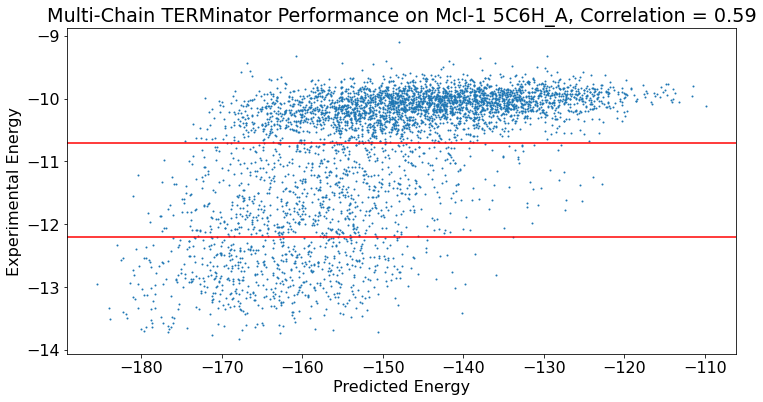

bench cors
B2CL1_SORTCERY
0.21070419413177577
0.10502666204454625
MCL1_SORTCERY
0.4655322822449879
0.13320525274073408
B2LA1_SORTCERY
0.36459459583262693
0.08850012830001612
all cors
0.34694369073646353
0.10477914697398548


In [9]:
plt.rcParams.update({'font.size': 16})

models = ['term_m']
runs = ['run0']
for m in models:
    bench_cors = {"B2CL1_SORTCERY": [], "MCL1_SORTCERY": [], "B2LA1_SORTCERY": []}
    for r in runs:
        print(f"{m}/{r}")
        alletab = glob.glob(f"../../bcl2/terminator_eval_condensed/{m}/{r}/*.etab.npy")
        for etab in alletab:
            model = os.path.basename(etab)
            if "BCL2" in model or "HUMAN" not in model:
                continue

            # sp = (model+"_35").split("_")
            model = model[:-9] + "_35" + model[-9:]
            sp = model.split("_")
            if len(sp) != 6:
                continue
            rec = sp[0]
            
            scoring = "dTERMenC"
            sp[-1] = scoring+sp[-1][:2]
            nmodel = "_".join(sp)

            #Load scoring matrix
            holo = np.load(etab)

            if len(holo) != CHAIN_LENGTH: # check for length 20 chain
                print(model,len(holo))
                continue

            # print("now scoring:", model)
            if nmodel not in PepBindEner:
                PepBindEner[nmodel] = dict()
            for seq in PepBindEner[rec+"_SORTCERY"]:
                #dTERMen pep are shorter, so need to adjust
                SeqToScore = str(seq)[2:CHAIN_LENGTH+2]
                #Score Seq
                ener = score_sec(SeqToScore,holo)
                PepBindEner[nmodel][seq] = ener
        
            
        PepBindEnerDF = pd.DataFrame(PepBindEner).dropna(axis=1, how='all').dropna(axis=0, how='all')

        #New name
        NameTest = ["B2CL1_SORTCERY","MCL1_SORTCERY","B2LA1_SORTCERY"]

#         all_cors = []

        for bench in NameTest:
#             print(bench)
            ExpRec = bench.split("_")[0]
            #Get bench
            OnlyBench = PepBindEnerDF.dropna(subset=[bench])

#             cors = []

            count = 0 
            for template in list(PepBindEnerDF.columns):
                if template == bench:continue
                #Need to be same receptor
                TempRec = template.split("_")[0]
                if TempRec != ExpRec:
                    continue
                    
                #Get PDB and model name
                sp = template.split("_")
                mod = sp[-1]
                if mod != 'dTERMenC35':
                    continue

                pdb = "_".join(sp[:4])
                if "MIN" in template:
                    pdb = "_".join(sp[:3])
                
                #Get data
                subdf = OnlyBench.dropna(subset=[template]).sort_values(by=template)
                Pred = subdf[template].values
                Exp = subdf[bench].values
                
                #Pearson product-moment correlation coefficients
                cor = np.corrcoef(Pred,Exp)[0][1]
                
                bench_cors[bench].append(cor)
#                 cors.append(cor)
                # print(template, cor)        
                #Get Enrich
                topbind = rankdata(Exp) < len(Exp) / 10
                enrich = np.sum(topbind[:len(Exp)//10])/(len(Exp)/10.0)*100
                
                if pdb == "MCL1_HUMAN_5C6H_A":
                    plt.figure(figsize=(12,6))
                    plt.scatter(Pred, Exp, s=1)
                    plt.title("Multi-Chain TERMinator Performance on Mcl-1 5C6H_A, Correlation = {}".format(round(cor,2)))
                    plt.xlabel("Predicted Energy")
                    plt.ylabel("Experimental Energy")
                    plt.axhline(y=-10.7, color='r', linestyle='-')
                    plt.axhline(y=-12.2, color='r', linestyle='-')
                    plt.show()

#             print(np.mean(cors))
#             print(np.std(cors))
#             all_cors.append(np.mean(cors))

    print("bench cors")
    all_cors = []
    for key in bench_cors:
        print(key)
        print(np.mean(bench_cors[key]))
        print(np.std(bench_cors[key]))
        all_cors.append(np.mean(bench_cors[key]))
    print("all cors")
    print(np.mean(all_cors))
    print(np.std(all_cors))